# Neural Fields for 3D Reconstruction

This notebook steps through the use of neural network representations for 3D reconstruction: namely, given a set of 2D camera images, we want to infer the structure of the 3D scene/object that produced the images. This problem is known as inverse rendering.


To start, we need to generate some training data. We will be using a rendering tool developed at SLAC: [gradoptics](https://github.com/Magis-slac/gradoptics).

In [ ]:
!pip install gradoptics

gradoptics is a ray-tracing simulator written in PyTorch. It uses the straight-line nature of light, as well as known interactions with optical elements, to render a scene.

In [1]:
import gradoptics as optics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from glob import glob

import torch
from scipy.spatial.transform import Rotation as R

We start out with a few helper functions to set up a system of cameras. In all of the following we assume that the object we're interested in imaging is at the origin $(0, 0, 0)$. 

`gradoptics` has a default camera orientation (along the $+x$ axis). We would like to place arbitrary cameras in 3D space and orient them to point at the object of interest (at the origin). The first function, `point_to_origin`, gives the appropriate Euler angle rotation to do this.

In [2]:
def point_to_origin(cam_position):
    # Default is point along positive x
    current_dir = torch.tensor([1., 0., 0.]).type(cam_position.dtype)
    
    # Vector pointing towards the origin
    new_dir = -cam_position/torch.norm(cam_position)
    
    # Get a perpendicular axis, handling axis aligned cases
    if torch.allclose(torch.abs(new_dir), torch.abs(current_dir)):
        axis = torch.tensor([0., 0., 1.]).double()
    else:
        axis = torch.cross(current_dir, new_dir)
     
    # Normalize
    axis *= 1/torch.norm(axis)
    
    # Get rotation angle via dot product
    angle = torch.acos(torch.dot(current_dir,new_dir)/(torch.norm(current_dir)*torch.norm(new_dir)))
    
    # Get Euler angles from rotation vector using scipy (right handed coordinate system)
    theta_x, theta_y, theta_z = R.from_rotvec(axis*angle).as_euler('xyz')
    
    # Gradoptics rotations need left handed coordinate system -- flip sign on y
    return theta_x, -theta_y, theta_z

We'll be operating at a fixed magnification, but adjusting camera positions and focal lengths. We can use the lensmakers formula to keep everything consistent/in focus

In [3]:
def calculate_focal_length(m, obj_distance):
    f =  obj_distance / ((1 / m) + 1)

    return f

`gradoptics` works in terms of `Scene` objects and optical elements within them. We can add multiple cameras to a scene, where a camera is a `Lens` and a `Sensor`. For this tutorial, we've fixed a magnification of `m=0.2` for all cameras and a sensor size of $400 \times 400$ pixels. 

`setup_scene` places an arbitrary number of cameras pointing at the origin in a scene, given sets of spherical coordinates (`thetas` for polar angles from the $+z$ axis, `phis` for azimuthal angles, and `rs` for radii, in meters).

In [4]:
def setup_scene(scene, thetas=[], phis=[], rs=[]):
    #Make sure the number of cameras matches between arguments
    assert len(thetas) == len(phis), "thetas and phis should have the same length"
    assert len(rs) == len(thetas), "rs and thetas should have the same length"
    
    n_cameras = len(thetas)
    
    # Given distance from object and magnification, calculate focal length for in focus object
    m = 0.2
    f = calculate_focal_length(m, rs[0])
    
    # Numerical aperture (size of camera opening, f-number)
    na = 1/1.4

    # Loop over cameras to add to scene
    for i_cam in range(n_cameras):
        # Avoid singular point with slight offset
        if thetas[i_cam] == 0:
            thetas[i_cam] = 1e-6
            
        # Get cartesian coordinates from spherical
        x_cam = rs[i_cam]*np.sin(thetas[i_cam])*np.cos(phis[i_cam])
        y_cam = rs[i_cam]*np.sin(thetas[i_cam])*np.sin(phis[i_cam])
        z_cam = rs[i_cam]*np.cos(thetas[i_cam])
        
        cam_pos = torch.tensor([x_cam, y_cam, z_cam])

        # Get orientation to point at origin and apply to lens
        angles = point_to_origin(cam_pos)
        transform = optics.simple_transform.SimpleTransform(*angles, cam_pos)
        lens = optics.PerfectLens(f=f, m=m, na=na,
                                  position = cam_pos,
                                  transform = transform)

        # Sensor position from lensmakers equation, rotated to match lens
        rel_position = torch.tensor([-f * (1 + m), 0, 0])                       
        rot_position = torch.matmul(transform.transform.float(), torch.cat((rel_position, torch.tensor([0]))))

        sensor_position = cam_pos + rot_position[:-1]
        viewing_direction = torch.matmul(transform.transform.float(), torch.tensor([1.,0,0,0]))

        sensor = optics.Sensor(position=sensor_position, viewing_direction=tuple(viewing_direction.numpy()),
                               resolution=(400,400), pixel_size=(2.4e-06, 2.4e-06),
                               poisson_noise_mean=2.31, quantum_efficiency=0.72)
        
        # Add sensor and lens to the scene
        scene.add_object(sensor)
        scene.add_object(lens)
        
    return scene, n_cameras

## Example scene/training data

One useful physics context for a 3D reconstruction is the imaging of clouds of atoms. This will be the data that we generate/use for this tutorial.

We here set up a scene with a 1mm Gaussian atom cloud at the origin, and three cameras pointing at it: one along the x-axis, one along the y-axis, and one along the z-axis. For later use, we define a spherical region of interest around the origin with radius 5mm, which will cover all the light that would be captured on our given sensor/be sufficiently large for our atom cloud.

In [5]:
scene = optics.Scene(optics.LightSourceFromDistribution(optics.AtomCloud(position=[0., 0., 0.])))
scene, n_cameras = setup_scene(scene, [np.pi/2, np.pi/2, 0.], [0., np.pi/2., 0.], [5e-2]*3)

scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.005, 
                                                         xc=0, yc=0, zc=0)

Visualizing the scene:

<IPython.core.display.Javascript object>


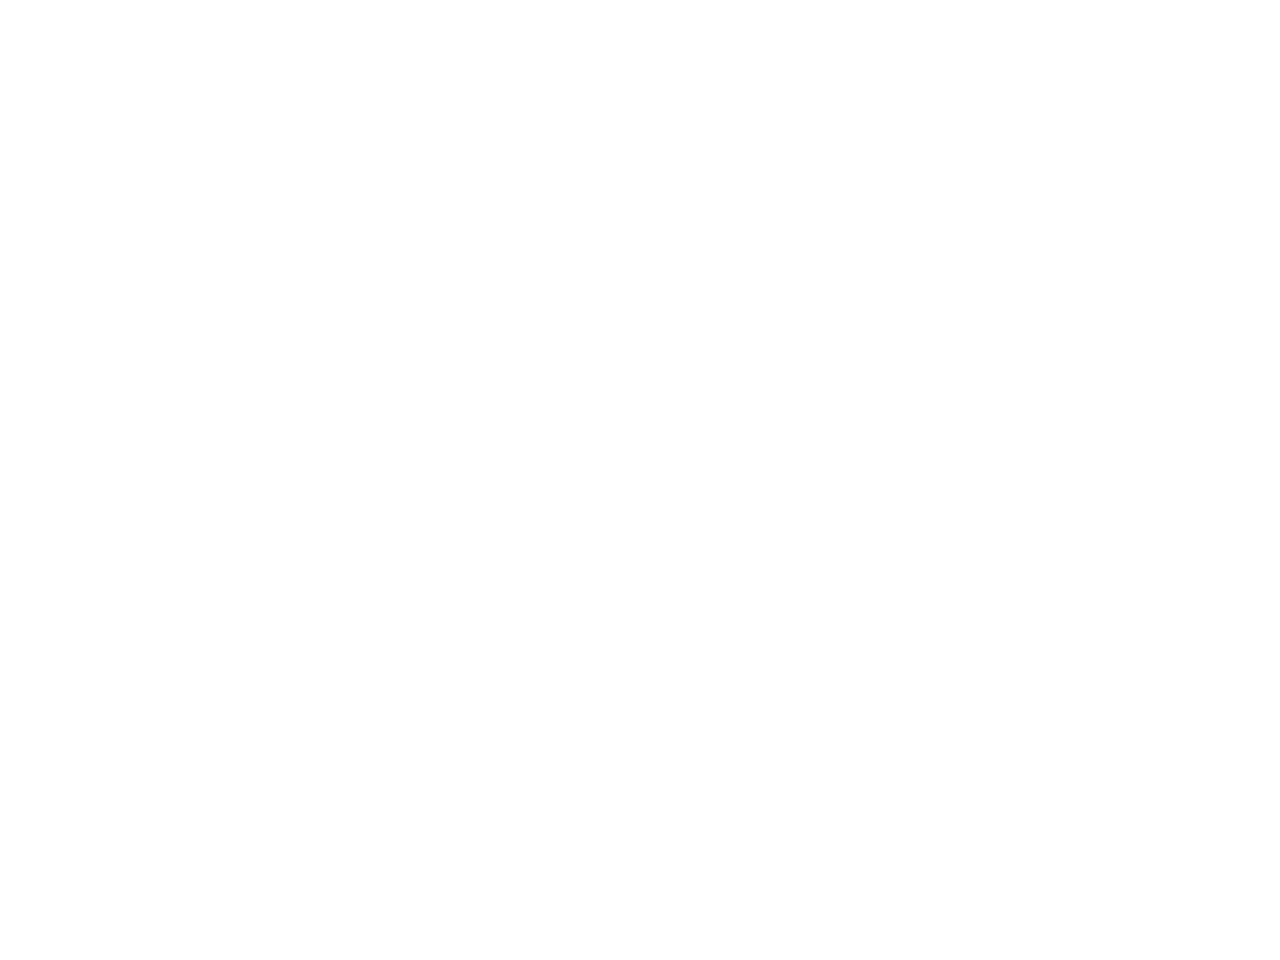

/sdf/group/magis/sgaz/sw/conda/envs/ml/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scene.plot(ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Rendering and backward ray tracing

Now that we have our scene and our cameras, we want to generate some images! We will do so using _backward ray tracing_.

In _forward ray tracing_, light is emitted in all directions from a given light source, and we keep track of the light that hits our camera sensors. This nicely corresponds to physical intuition, but is inefficient: our cameras don't cover a large area of space, so many light rays need to be generated to get good images.

In _backward ray tracing_, we say that we only care about light that hits pixels on our camera sensors. Since the light rays translate through our system along the same paths moving forward or backward in time, we instead generate rays at each of our camera pixels. By _integrating_ along these light rays through the object of interest, we can calculate the contribution of a light source to each pixel. 


To do this backward ray tracing, we need to generate appropriate rays. A ray is defined by an origin $\mathbf{o}$ and a direction $\mathbf{d}$, with a given point along a ray at time $t$ given by
\begin{equation}
\mathbf{r}(t) = \mathbf{o} + t\cdot \mathbf{d}
\end{equation}

We therefore first need to get coordinates of each pixel (the origins of each of our rays).

In [7]:
def get_pixel_coords(sensor):
    # Pixel coordinates in camera space
    x = torch.linspace(-sensor.pixel_size[0]*sensor.resolution[0]/2 + sensor.pixel_size[0]/2,
                         sensor.pixel_size[0]*sensor.resolution[0]/2 - sensor.pixel_size[0]/2, 
                         sensor.resolution[0])

    y = torch.linspace(-sensor.pixel_size[1]*sensor.resolution[1]/2 + sensor.pixel_size[1]/2,
                         sensor.pixel_size[1]*sensor.resolution[1]/2 - sensor.pixel_size[1]/2, 
                         sensor.resolution[1])
    
    pix_x, pix_y = torch.meshgrid(x, y)
    
    pix_z = torch.zeros((sensor.resolution[0], sensor.resolution[1]))
    
    all_coords = torch.stack([pix_x, pix_y, pix_z], dim=-1).reshape((-1, 3)).double()
    
    # Use transforms from above setup to go from pixel space to real (world) space
    return sensor.c2w.apply_transform_(all_coords)

To complete the rays, we then need a set of directions. For simplicity, we here consider the case of a pinhole camera (all the rays start from pixels and pass through the center of the lens).

In [8]:
def get_rays_pinhole(sensor, lens, nb_rays=None, ind=None, device='cuda', return_ind=False):
    
    if ind is None:
        #Set up for ray batching -- nb_rays switches between all pinhole rays or random batches
        if nb_rays == None or nb_rays == sensor.resolution[0]*sensor.resolution[1]:
            ind = torch.arange(0, sensor.resolution[0]*sensor.resolution[1])
        else:
            ind = torch.randint(0, sensor.resolution[0]*sensor.resolution[1], (nb_rays,))
    
    # Get origins
    all_pix_coords = get_pixel_coords(sensor)  
    origins = all_pix_coords[ind]
    
    #Get directions to center of lens
    lens_center = lens.transform.transform[:-1, -1]
    
    directions = optics.batch_vector(lens_center[None, 0] - origins[:, 0],
                                     lens_center[None, 1] - origins[:, 1],
                                     lens_center[None, 2] - origins[:, 2]).type(origins.dtype)

    # Set up rays
    rays_sensor_to_lens = optics.Rays(origins, directions, device=device)
    
    if return_ind:
        return rays_sensor_to_lens, ind
    else:
        return rays_sensor_to_lens

Backward ray tracing relies on doing a line integral along each ray. We do so by sampling a set of points along each ray and summing up the contributions at each of those points. Here we use a _hierarchical sampling_, which first spaces a set of points uniformly along the ray, and then does an importance sampling of additional points with notable density to "focus" on regions of interest. We do a stratified sampling on top of this, perturbing the uniformly spaced points to better approximate a continuous integral.

Our object of interest is a transparent atom cloud, meaning that we only integrate the density: the contribution of a ray to a given pixel intensity is given by:
\begin{equation}
C(\mathbf{r}) \propto \int \sigma(\mathbf{r}(t))dt
\end{equation}

For other contexts (such as [NeRF](https://www.matthewtancik.com/nerf)), these integrals include a view (ray direction) dependent color as well as a transmittance term (the probability of a light ray terminating as it moves through a given density).


The integration is done only within the spherical region of interest that we defined above. Generating images then is done as follows:

In [9]:
# Define an integrator
from gradoptics.integrator import HierarchicalSamplingIntegrator

# 64 uniformly spaced points, 64 additional points
integrator = HierarchicalSamplingIntegrator(64, 64)

# Loop over cameras
targets = []
for i_cam in tqdm(range(n_cameras)):
    # Generate rays for each camera (all pixels at once). i_cam*2 gives all sensor idxs, lenses are i_cam*2+1
    incident_rays = get_rays_pinhole(scene.objects[i_cam*2], scene.objects[i_cam*2+1])
    
    # Trace rays through the scene (includes the integration)
    intensities = optics.backward_ray_tracing(incident_rays, scene, 
                                                scene.light_source, integrator, max_iterations=3)
    
    # Store the result for a given camera
    targets.append(intensities.cpu().clone().reshape(scene.objects[i_cam*2].resolution))
    
    del intensities

100%|██████████| 3/3 [00:28<00:00,  9.48s/it]


## Resulting images

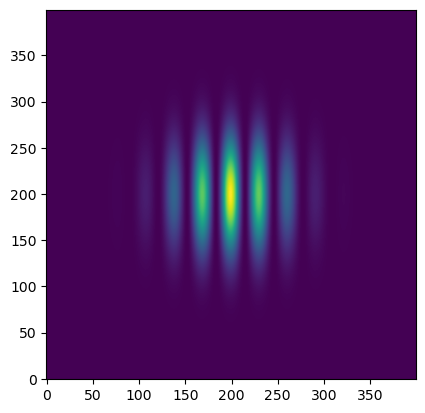

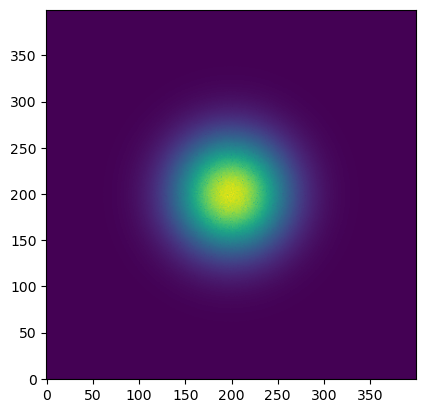

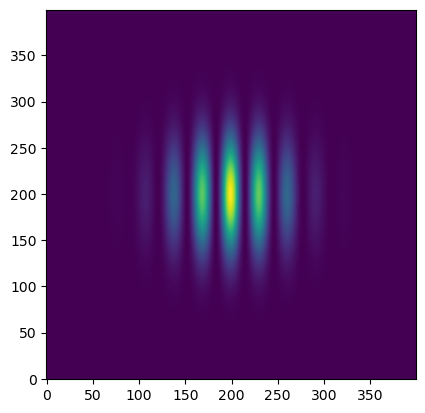

In [10]:
%matplotlib inline
for i in range(len(targets)):
    plt.imshow(targets[i].T, origin='lower')
    plt.show()

## 3D reconstruction

We now have some "captured" data and we know the optical setup. Assuming we know only that, can we figure out what our atom cloud looks like in 3D?

We do so using an analysis-by-synthesis approach: we start out with some initial guess of the 3D structure, simulate a set of images as we did above, compare to our "captured" data, and adjust our 3D model to minimize the difference between the guess and the data.

Here, our 3D model is parametrized by a class of neural networks called SIRENs. This is not a unique choice! But it works well in practice.

Within `gradoptics`, we can set a neural network as a light source and do rendering in exactly the same way as above.

In [11]:
from models.siren import Siren
import torch.nn as nn
from gradoptics import LightSourceFromNeuralNet

First we define the SIREN model

In [12]:
device = 'cuda'

in_features = 3
hidden_features = 256
hidden_layers = 3
out_features = 1

model = Siren(in_features, hidden_features, hidden_layers, out_features,
              outermost_linear=True, outermost_linear_activation=nn.Softplus()).double().to(device)

Then we set up a scene for training. This has all of the same cameras as the scene we used above, but the light source is now a neural network with learnable parameters.

In [13]:
# NN light source using slightly tighter bounding sphere
nn_light_source = LightSourceFromNeuralNet(model, optics.BoundingSphere(radii=0.003, 
                                                                           xc=0, yc=0, zc=0),
                                                    rad=0.003, x_pos=0)
scene_train = optics.Scene(nn_light_source)

# Add sensors/lenses from scene above
for i in range(len(scene.objects)):
    scene_train.add_object(scene.objects[i])

We do a batch gradient descent with each batch drawn from a given camera sensor. We'll do a quick training for demonstration. Loss values are large due to fairly large light collection. 2000 gradient iterations (~34 epochs) takes around 7 minutes.

In [14]:
# Batch size
batch_size = 8192

# Loss function -- mean squared error between pixels
loss_fn = torch.nn.MSELoss()

# Same integrator as above
integrator = HierarchicalSamplingIntegrator(64, 64)

# Optimizer
optimizer = torch.optim.Adam(scene_train.light_source.network.parameters(), lr=1e-4)

# Keep track of losses
losses = []

for i_iter in tqdm(range(2000)):
    # Choose a random camera
    i_cam = torch.randint(n_cameras, (1,))
    
    # Grab a random batch of rays
    rays, ind = get_rays_pinhole(scene.objects[i_cam*2], 
                                 scene.objects[i_cam*2+1], nb_rays=batch_size, device='cuda', return_ind=True)
    
    # Get corresponding pixels from target images
    target_vals = targets[i_cam].flatten()[ind]
    
    # Ray trace using neural network light source
    intensities = optics.backward_ray_tracing(rays, scene_train, 
                                             scene_train.light_source, integrator, max_iterations=3)
    
    # Calculate the loss -- 1e9 scaling is a result of unnormalized PDF in atom cloud
    loss = loss_fn(intensities*1e9, target_vals.double().cuda())
    
    # Calculate gradients and update network parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Keep track of results
    losses.append(loss.item())
    if i_iter % 100 == 0:
        print(loss.item())
        
        with torch.no_grad():
            torch.save(scene_train.light_source.network.state_dict(), 
                       f'model_{i_iter}iter_tutorial.pt')
        with open('losses_tutorial.pkl', 'wb') as file:
            pickle.dump(losses, file)

  0%|          | 1/2000 [00:01<38:47,  1.16s/it]

10103067507659.389


  5%|▌         | 101/2000 [01:18<07:08,  4.43it/s]

331569952599.2987


 10%|█         | 201/2000 [01:40<06:53,  4.35it/s]

128670714801.23386


 15%|█▌        | 301/2000 [02:02<06:33,  4.31it/s]

75135716422.48395


 20%|██        | 401/2000 [02:24<06:02,  4.41it/s]

45634193155.85335


 25%|██▌       | 501/2000 [02:46<05:44,  4.35it/s]

38828669500.900925


 30%|███       | 601/2000 [03:08<05:11,  4.49it/s]

30704374945.01764


 35%|███▌      | 701/2000 [03:30<04:52,  4.44it/s]

23056498906.99621


 40%|████      | 801/2000 [03:52<04:29,  4.45it/s]

17075174937.589163


 45%|████▌     | 901/2000 [04:15<04:09,  4.40it/s]

12274019054.275894


 50%|█████     | 1001/2000 [04:37<04:15,  3.91it/s]

11478613054.687895


 55%|█████▌    | 1101/2000 [04:59<03:21,  4.46it/s]

9786207260.15731


 60%|██████    | 1201/2000 [05:21<03:03,  4.37it/s]

7396856649.644927


 65%|██████▌   | 1301/2000 [05:43<02:37,  4.43it/s]

6592508939.52388


 70%|███████   | 1401/2000 [06:05<02:16,  4.39it/s]

6293585739.159177


 75%|███████▌  | 1501/2000 [06:27<01:59,  4.18it/s]

5004707598.542511


 80%|████████  | 1601/2000 [06:49<01:30,  4.43it/s]

4417743955.201153


 85%|████████▌ | 1701/2000 [07:11<01:06,  4.47it/s]

4460642517.628504


 90%|█████████ | 1801/2000 [07:33<00:44,  4.50it/s]

3953375123.830625


 95%|█████████▌| 1901/2000 [07:55<00:22,  4.48it/s]

3580583458.7905397


100%|██████████| 2000/2000 [08:17<00:00,  4.02it/s]


## Analyze Results

First, plotting the loss, it should go down. If the loss is not flat, training for longer will improve the quality of results!

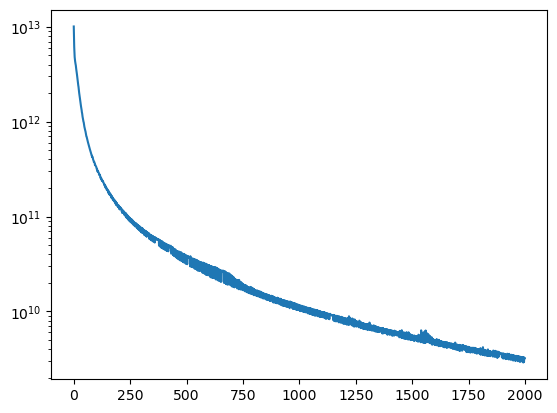

In [15]:
%matplotlib inline
plt.plot(losses)
plt.yscale('log')

Then let's visualize the densities: first we define some sampled grid of points

In [16]:
# Keep square grid within training sphere
rad = 0.003
bound = 1/np.sqrt(3.)

# 100 x 100 x 100 cube
n_side=100

# Inputs to NN model are centered and scaled
grid = torch.cartesian_prod(torch.linspace(-bound, bound, n_side),
                            torch.linspace(-bound, bound, n_side),
                            torch.linspace(-bound, bound, n_side)).cuda().double()

# But also define in real space
grid_real = torch.cartesian_prod(torch.linspace(-rad*bound, rad*bound, n_side),
                            torch.linspace(-rad*bound, rad*bound, n_side),
                            torch.linspace(-rad*bound, rad*bound, n_side)).cuda().double()

# Calculate model density from NN and "true" density from pdf
with torch.no_grad():
    densities = model(grid)[0].reshape((n_side, n_side, n_side)).cpu()
    pdf_vals = scene.light_source.pdf(grid_real).reshape((n_side, n_side, n_side)).cpu()

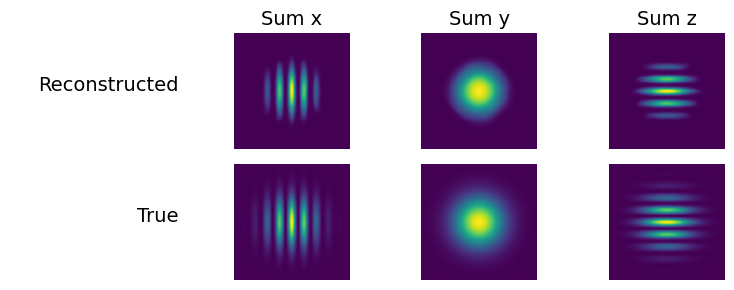

In [17]:
%matplotlib inline
fig, ax = plt.subplots(2, 4, figsize=(8,3))

ax[0, 0].text(0.9, 0.5, "Reconstructed", ha='right', fontsize=14)
ax[0, 0].axis('off')

ax[1, 0].text(0.9, 0.5, "True", ha='right', fontsize=14)
ax[1, 0].axis('off')

ax[0, 1].imshow(densities.sum(dim=0).T, origin="lower")
ax[0, 1].set_title('Sum x', fontsize=14)
ax[0, 1].axis('off')
ax[1, 1].imshow(pdf_vals.sum(dim=0).T, origin="lower")
ax[1, 1].axis('off')

ax[0, 2].imshow(densities.sum(dim=1).T, origin="lower")
ax[0, 2].set_title('Sum y', fontsize=14)
ax[0, 2].axis('off')
ax[1, 2].imshow(pdf_vals.sum(dim=1).T, origin="lower")
ax[1, 2].axis('off')

ax[0, 3].imshow(densities.sum(dim=2).T, origin="lower")
ax[0, 3].set_title('Sum z', fontsize=14)
ax[0, 3].axis('off')
ax[1, 3].imshow(pdf_vals.sum(dim=2).T, origin="lower")
ax[1, 3].axis('off')

plt.tight_layout()
plt.show()

Then visualize as model trains by loading in saved models. `celluloid` is just a wrapper for matplotlib animations.

In [18]:
f_pattern = 'model_*iter_tutorial.pt'
n_checkpoints = len(glob(f_pattern))

last = (n_checkpoints-1)*100

all_densities = []
with torch.no_grad():
    for n_iter in tqdm(np.arange(0, last+1, 100)):
        fname = f_pattern.replace("*iter", "{n_iter}iter").format(n_iter=n_iter)
        model.load_state_dict(torch.load(fname))
        densities = model(grid)[0].reshape((n_side, n_side, n_side)).cpu()
        all_densities.append(densities.clone())

100%|██████████| 20/20 [00:01<00:00, 14.42it/s]


<IPython.core.display.Javascript object>


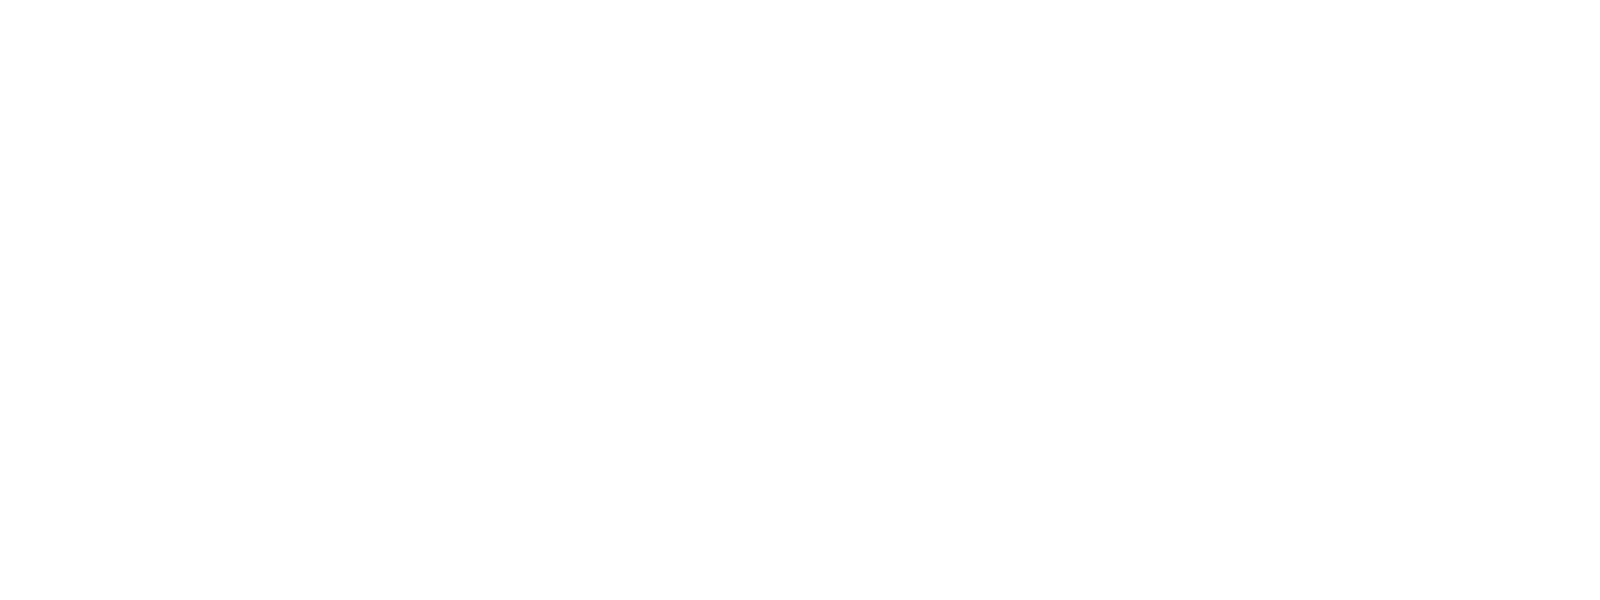

In [19]:
%matplotlib notebook
from celluloid import Camera
fig, ax = plt.subplots(2, 4, figsize=(8,3))
camera = Camera(fig)

for i in range(len(all_densities)):
    ax[0, 0].text(0.9, 0.5, "Reconstructed", ha='right', fontsize=14)
    ax[0, 0].axis('off')

    ax[1, 0].text(0.9, 0.5, "True", ha='right', fontsize=14)
    ax[1, 0].axis('off')

    ax[0, 1].imshow(all_densities[i].sum(dim=0).T, origin="lower")
    ax[0, 1].set_title('Sum x', fontsize=14)
    ax[0, 1].axis('off')
    ax[1, 1].imshow(pdf_vals.sum(dim=0).T, origin="lower")
    ax[1, 1].axis('off')

    ax[0, 2].imshow(all_densities[i].sum(dim=1).T, origin="lower")
    ax[0, 2].set_title('Sum y', fontsize=14)
    ax[0, 2].axis('off')
    ax[1, 2].imshow(pdf_vals.sum(dim=1).T, origin="lower")
    ax[1, 2].axis('off')

    ax[0, 3].imshow(all_densities[i].sum(dim=2).T, origin="lower")
    ax[0, 3].set_title('Sum z', fontsize=14)
    ax[0, 3].axis('off')
    ax[1, 3].imshow(pdf_vals.sum(dim=2).T, origin="lower")
    ax[1, 3].axis('off')

    plt.tight_layout()
    camera.snap()

animation = camera.animate()
animation.save('tutorial_training.gif')

We can also generate a set of images as we move around in 3D (even where we haven't trained with cameras!)

In [20]:
# NN light source using slightly tighter bounding sphere
nn_light_source = LightSourceFromNeuralNet(model, optics.BoundingSphere(radii=0.003, 
                                                                           xc=0, yc=0, zc=0),
                                                    rad=0.003, x_pos=0)

all_azim_angles = np.linspace(0, 2*np.pi, 30)

# Same integrator as above
integrator = HierarchicalSamplingIntegrator(64, 64)

batch_size = 8192

with torch.no_grad():
    interp_ims = []
    for azim in tqdm(all_azim_angles):
        scene_interp = optics.Scene(nn_light_source)

        scene_interp, n_cameras = setup_scene(scene_interp, [np.pi/2], [azim], [5e-2])

        all_ind = torch.arange(0, scene_interp.objects[0].resolution[0]*scene_interp.objects[0].resolution[1])
        
        ind_batches = all_ind.split(batch_size)
        
        all_intensities = []
        for ind_batch in ind_batches:
            # Generate rays for each camera (all pixels at once). i_cam*2 gives all sensor idxs, lenses are i_cam*2+1
            incident_rays = get_rays_pinhole(scene_interp.objects[0], scene_interp.objects[1], ind=ind_batch)

            # Trace rays through the scene (includes the integration)
            intensities = optics.backward_ray_tracing(incident_rays, scene_interp, 
                                                        scene_interp.light_source, integrator, max_iterations=3)
            
            all_intensities.append(intensities.cpu().clone())
            
            del intensities
            
        all_intensities = torch.cat(all_intensities)

        # Store the result for a given camera
        interp_ims.append(all_intensities.cpu().clone().reshape(scene_interp.objects[0].resolution))


100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


Do the same for the true object

In [21]:
true_light_source = optics.LightSourceFromDistribution(optics.AtomCloud(position=[0., 0., 0.]))

all_azim_angles = np.linspace(0, 2*np.pi, 30)

# Same integrator as above
integrator = HierarchicalSamplingIntegrator(64, 64)

with torch.no_grad():
    interp_ims_true = []
    for azim in tqdm(all_azim_angles):
        scene_interp = optics.Scene(true_light_source)
        scene_interp.light_source.bounding_shape = optics.BoundingSphere(radii=0.005, 
                                                         xc=0, yc=0, zc=0)

        scene_interp, n_cameras = setup_scene(scene_interp, [np.pi/2], [azim], [5e-2])
        
        # Generate rays for each camera (all pixels at once). i_cam*2 gives all sensor idxs, lenses are i_cam*2+1
        incident_rays = get_rays_pinhole(scene_interp.objects[0], scene_interp.objects[1])

        # Trace rays through the scene (includes the integration)
        intensities = optics.backward_ray_tracing(incident_rays, scene_interp, 
                                                    scene_interp.light_source, integrator, max_iterations=3)


        # Store the result for a given camera
        interp_ims_true.append(intensities.cpu().clone().reshape(scene_interp.objects[0].resolution))
        
        del intensities


100%|██████████| 30/30 [00:02<00:00, 13.25it/s]


<IPython.core.display.Javascript object>


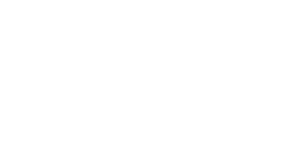

In [22]:
%matplotlib notebook
fig, ax = plt.subplots(2, 2, figsize=(5, 4))
camera = Camera(fig)

for i in range(len(interp_ims)):
    ax[0, 0].text(0.9, 0.5, "Reconstructed", ha='right', fontsize=14)
    ax[0, 0].axis('off')

    ax[1, 0].text(0.9, 0.5, "True", ha='right', fontsize=14)
    ax[1, 0].axis('off')

    ax[0, 1].imshow(interp_ims[i].T, origin='lower')
    ax[1, 1].imshow(interp_ims_true[i].T, origin='lower')
    camera.snap()
    
anim = camera.animate()
anim.save('interp_around.gif')

Not perfect! Some reconstruction artifacts where we don't have information (diagonals, etc).

Try adding in more cameras, training for longer -- see how results improve!